# Сборный проект

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/GameCube-Set.jpg/640px-GameCube-Set.jpg 'Evan-Amos')

# Описание проекта
Имеется файл с историческими данными о продажах игр, оценках пользователей и экспертов, жанрами и платформами (например, _Xbox_ или _PlayStation_). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Файл с данными был подготовлен в 2016 году, исследование проводится для 2017 года.

## Загрузка и предварительное изучение данных

Загрузим файл с данными и посмотрим, какая информация нам доступна.

In [298]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [299]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (15, 5)})

In [300]:
! gdown 1ano3cQdAcXdu45OxOCKHSryct0snEi6X

Downloading...
From: https://drive.google.com/uc?id=1ano3cQdAcXdu45OxOCKHSryct0snEi6X
To: /content/games.csv
100% 1.18M/1.18M [00:00<00:00, 117MB/s]


In [301]:
df = pd.read_csv('/content/games.csv')

In [302]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Итак, у нас в распоряжении файл с более чем 16 тысячами записей об играх. Неплохо! Уже видно, что столбцы для аккуратности можно переименовать, и что в некоторых столбцах много пропусков.

Посмотрим, какая информация нам доступна:
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации _ESRB (англ. Entertainment Software Rating Board)_. Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Подготовка данных

Начнём с переименования столбцов. Так будет аккуратнее и облегчит дальнейшую обработку.

In [304]:
df.columns = df.columns.str.lower()

In [305]:
# check
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Теперь изменим типы данных в некоторых колонках. Это позволит немного съэкономить память и работать будет приятнее. Очевидно, что колонку `year_of_release` разумнее хранить в целочисленном типе данных _int_.

In [306]:
df['year_of_release'] = df['year_of_release'].astype('Int64')

Ещё одним очевидным решением было бы преобразование колонки _user_score_ в тип данных _float_, но при попытке это сделать мы натыкаемся на запись _tbd_, которую мы обработаем в дальнейшем. Типы данных в остальных колонках выглядят правильно.

Посмотрим на пропуски данных в отдельных колонках.

In [307]:
df['name'].isna().sum()

2

Ох. Два пропуска в этой колонке выглядят печально. Давайте посмотрим на сами записи.

In [308]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Две игры, вышедшие в 1993 году на платформе _GEN_ (полагаю, что речь идёт о [Sega Genesis](https://en.wikipedia.org/wiki/Sega_Genesis)). Одна игра не продавалась в Японии, а вторая — только в Японии и продавалась. Данных о рейтингах нет. Имеющейся информации недостаточно для восстановления названий. Пока оставим эти два пропуска как есть. Скорее всего они возникли из-за технической ошибки.

In [309]:
df['year_of_release'].isna().sum()

269

In [310]:
df[df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Итак, мы видим, что в колонке `year_of_release` 269 записей с пропусками. Первоначальное предположение было в том, что это очень старые игры, для которых не сохранилось данных о точном годе выпуска, но цифра 2004 в названии первой намекает, что это не игры из прошлого тысячелетия. Скорее всего пропуски возникли из-за технической ошибки. Если при дальнейшей работе их надо будет заполнить, то можно привязаться к среднему году выхода игр для платформы, скорее всего так мы угадаем более точно.

In [311]:
df['genre'].isna().sum()

2

In [312]:
df[df['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


О, а эти записи мы уже видели, когда изучали пропуски данных в столбце `name`!

In [313]:
df['critic_score'].isna().sum()

8578

In [314]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

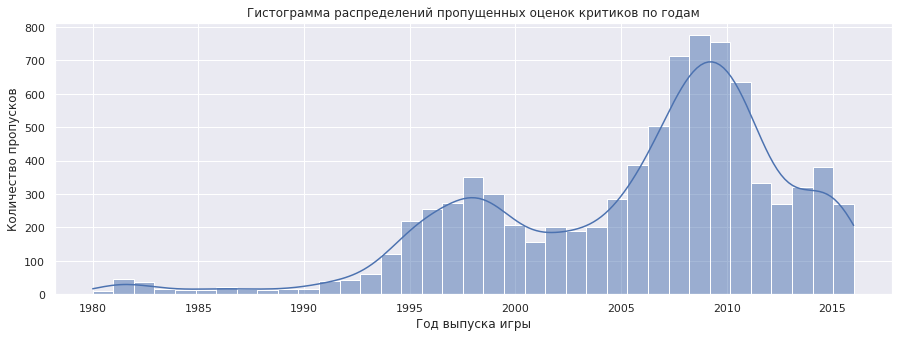

In [315]:
sns.histplot(data=df.loc[df['critic_score'].isna(), 'year_of_release'], 
             kde=True)\
.set(title='Гистограмма распределений пропущенных оценок критиков по годам',
     ylabel='Количество пропусков',
     xlabel='Год выпуска игры');

In [316]:
df['user_score'].isna().sum()

6701

In [317]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [318]:
df['rating'].isna().sum()

6766

In [319]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

В колонках `critic_score`, `user_score`, `rating` также довольно много пропусков. На наш взгляд это легко объяснимо: врядли для всех игр есть такие данные. Предположение о том, что пропуски в основном относятся к старым играм,  не оправдалось. Критики и пользователи могли просто не оценивать определённые игры.

Отдельно рассмотрим запись _tbd_ в колонке `user_score`. Скорее всего TBD — аббревиатура, расшифровывающаяся как _To be Decided/Determined/Done_. В нашем случае аббревиатуру вполне можно интерпретировать как отсутствие значения. Заменим её на _NaN_ и сконвертируем весь столбец в тип _float_.

In [320]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

In [321]:
# check
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [322]:
df['user_score'] = df['user_score'].astype(float)

In [323]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


Подсчитаем общие продажи во всех регионах и запишем их в отдельный столбец.

In [324]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [325]:
# check
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Наконец, проверим данные на явные дупликаты.

In [326]:
df.duplicated().sum()

0

Явных дупликатов по всем колонкам не обнаружено. Посмотрим, есть ли они в парах «название—платформа».

In [327]:
df.duplicated(subset=['name', 'platform']).sum()

5

In [328]:
df[df.duplicated(subset=['name', 'platform'])].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T,1.25
4127,Sonic the Hedgehog,PS3,<NA>,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+,0.48
11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T,0.08
14244,NaN,GEN,1993,NaN,0.0,0.00,0.03,0.00,NaN,NaN,NaN,0.03
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E,0.01


In [329]:
df[df['name'] == 'Need for Speed: Most Wanted'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
253,Need for Speed: Most Wanted,PS2,2005,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T,4.37
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN,2.81
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T,1.56
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T,1.25
1998,Need for Speed: Most Wanted,XB,2005,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T,1.04


In [330]:
df[df['name'] == 'Madden NFL 13'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
507,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E,2.85
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,2.56
3986,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E,0.50
5887,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E,0.30
7066,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E,0.23


Неявные дубликаты в подмножестве «название—платформа» действительно есть. Но судя по всему, они попали в данные не по ошибке — похоже, что это издания игр на разных платформах и переиздания игр под старыми названиями. В этом случае удалять их будет неправильно, так как эти записи добавляют информацию об общих продажах.

**Вывод:**

На этапе подготовки данных было выявлено несколько проблем с данными:
* неудачные названия колонок;
* наличие пропусков данных в некоторых колонках;
* неподоходящие типы данных в колонках `user_score` и `year_of_release`.

В ходе работы с данными колонки были переименованы, типы данных изменены на более подходящие. Пропуски данных были обнаружены, но оставлены без изменений, чтобы избежать возможного искажения данных.

## Исследовательский анализ данных
### Определение количества выпускаемых игр по годам
Давайте посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

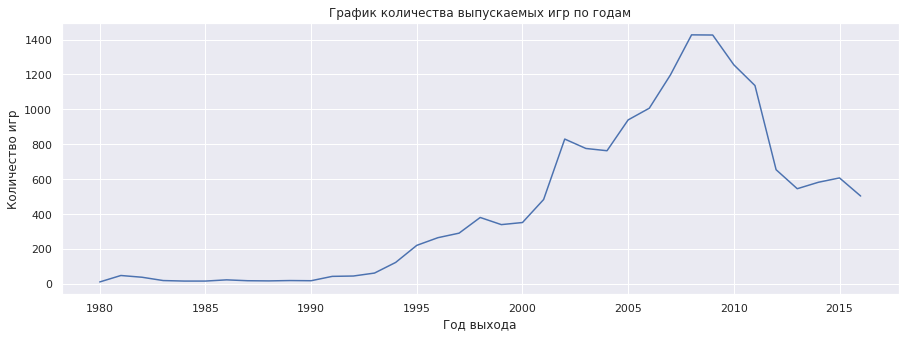

In [331]:
sns.lineplot(data=df.groupby('year_of_release').agg({'name': 'count'}),
             legend=False)\
.set(title='График количества выпускаемых игр по годам',
     ylabel='Количество игр',
     xlabel='Год выхода');

Дополнительно построим аналогичный график, но исключим из него издания игр на различных платформах. То есть, например, если какая-то игра одновременно вышла и на _Xbox_ и на _PS4_ и на _PC_, то на график попадёт только одна запись. При этом переиздания игр (вышедшие в разные годы) будем учитывать как отдельные игры.

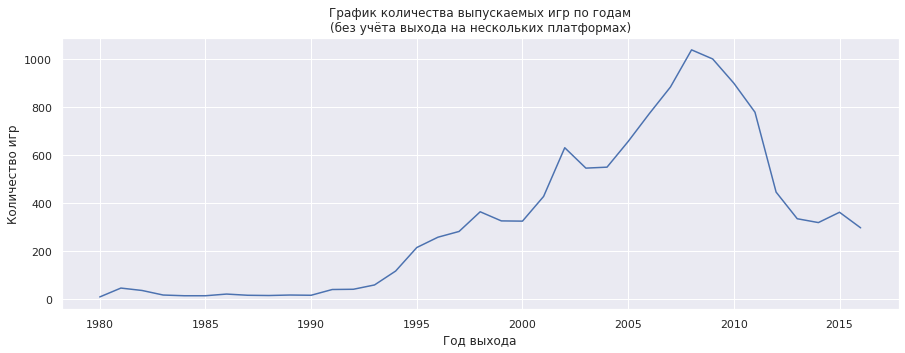

In [332]:
df_nodf = df.drop_duplicates(subset=['name', 'year_of_release'])

sns.lineplot(data=df_nodf.groupby('year_of_release').agg({'name': 'count'}),
             legend=False)\
.set(title="""График количества выпускаемых игр по годам
(без учёта выхода на нескольких платформах)""",
     ylabel='Количество игр',
     xlabel='Год выхода');

**Вывод:** 

В имеющемся файле больше всего записей о выпуске игр относятся к 2008 году. Вплоть до 2008 года количество выпускаемых в год игр почти непрерывно росло, а после 2008 года начало резко снижаться. Чтобы сделать вывод о важности данных за все периоды пока не хватает данных.

### Исследование изменения продаж по платформам

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Определим за какой характерный срок появляются новые и исчезают старые платформы?

In [333]:
df.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False).head()

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12


Получены пять платформ с наибольшими суммарными продажами:
* [Play Station 2](https://en.wikipedia.org/wiki/PlayStation_2);
* [Xbox 360](https://en.wikipedia.org/wiki/Xbox_360);
* [Play Station 3](https://en.wikipedia.org/wiki/PlayStation_3);
* [Wii](https://en.wikipedia.org/wiki/Wii);
* [Nintendo DS](https://en.wikipedia.org/wiki/Nintendo_DS).

Построим графики зависимостей общих продаж по годам для каждой платформы.

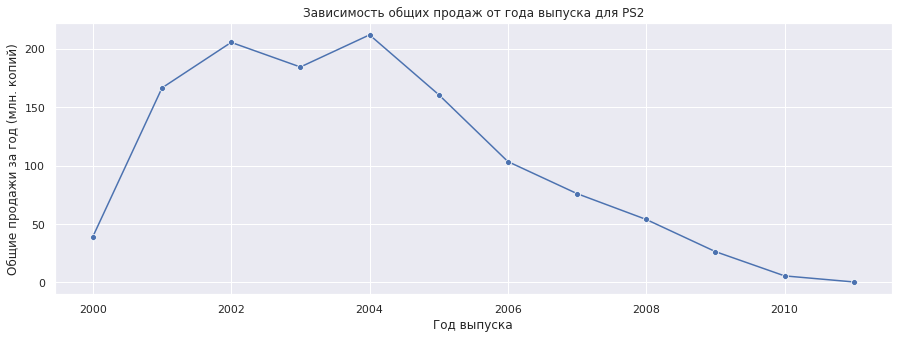

In [334]:
sns.lineplot(data=df.query('platform == "PS2"')\
             .groupby('year_of_release').agg({'total_sales': 'sum'}),
             markers=True, legend=False)\
             .set(title='Зависимость общих продаж от года выпуска для PS2',
                  xlabel='Год выпуска',
                  ylabel='Общие продажи за год (млн. копий)');

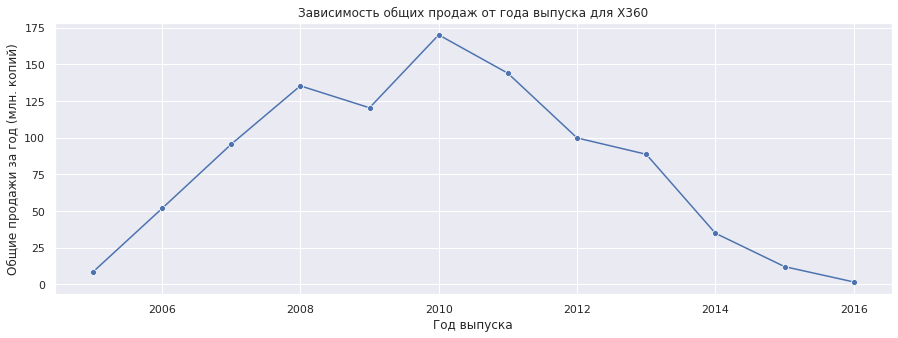

In [335]:
sns.lineplot(data=df.query('platform == "X360"')\
             .groupby('year_of_release').agg({'total_sales': 'sum'}),
             markers=True, legend=False)\
             .set(title='Зависимость общих продаж от года выпуска для X360',
                  xlabel='Год выпуска',
                  ylabel='Общие продажи за год (млн. копий)');

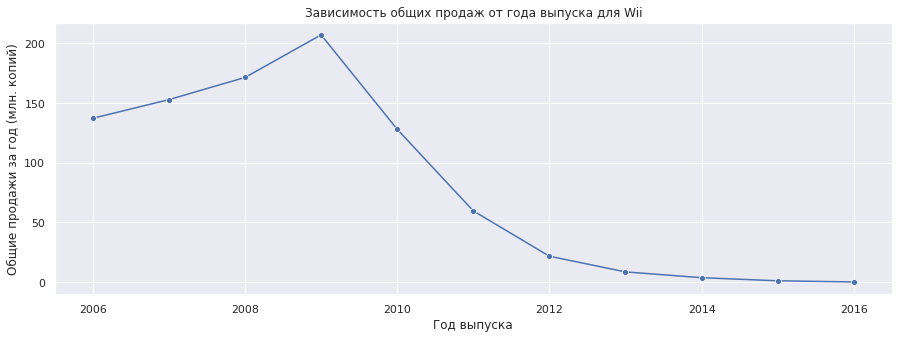

In [336]:
sns.lineplot(data=df.query('platform == "Wii"')\
             .groupby('year_of_release').agg({'total_sales': 'sum'}),
             markers=True, legend=False)\
             .set(title='Зависимость общих продаж от года выпуска для Wii',
                  xlabel='Год выпуска',
                  ylabel='Общие продажи за год (млн. копий)');

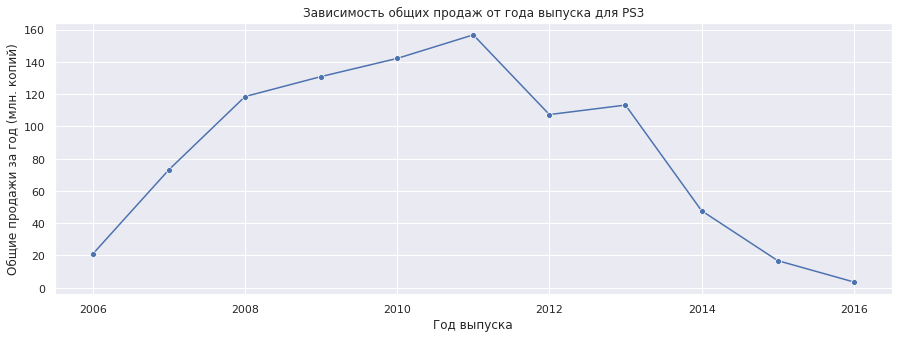

In [337]:
sns.lineplot(data=df.query('platform == "PS3"')\
             .groupby('year_of_release').agg({'total_sales': 'sum'}),
             markers=True, legend=False)\
             .set(title='Зависимость общих продаж от года выпуска для PS3',
                  xlabel='Год выпуска',
                  ylabel='Общие продажи за год (млн. копий)');

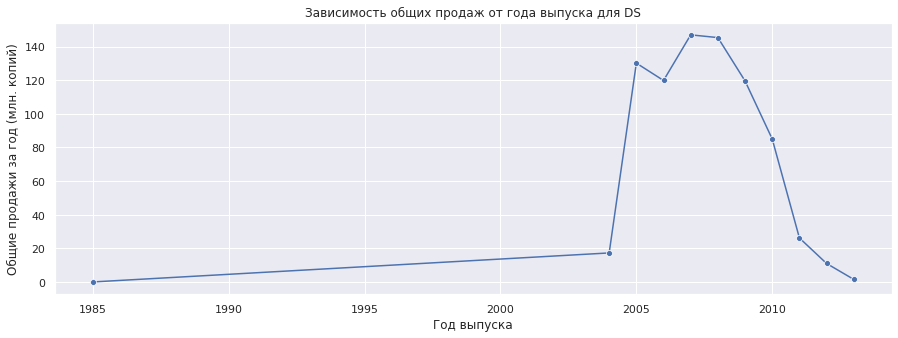

In [338]:
sns.lineplot(data=df.query('platform == "DS"')\
             .groupby('year_of_release').agg({'total_sales': 'sum'}),
             markers=True, legend=False)\
             .set(title='Зависимость общих продаж от года выпуска для DS',
                  xlabel='Год выпуска',
                  ylabel='Общие продажи за год (млн. копий)');

In [339]:
df[(df['platform'] == 'DS') & (df['year_of_release'] == 1985)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN,0.02


В данных по платформе _Nintendo DS_ обнаружилась подозрительная запись про игру _Strongest Tokyo University Shogi DS_, вышедшую в 1985 году (сама платформа _Nintendo DS_ появилась в 2004 году). О возникшей проблеме следует сообщить отделу, предоставившему данные.

Перестроим последний график без этой игры, чтобы масштаб стал более наглядным.

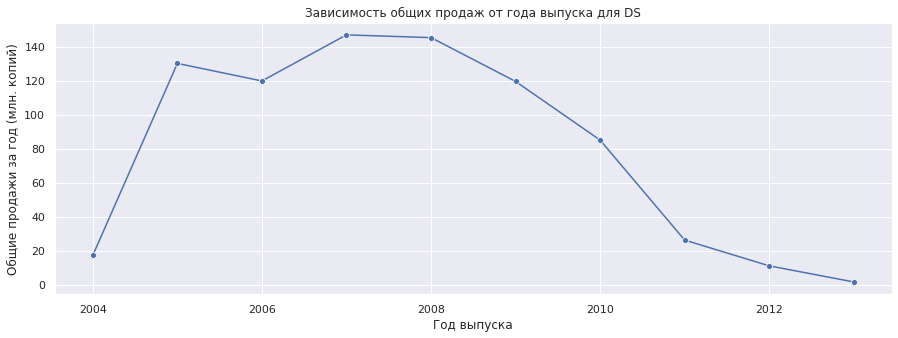

In [340]:
sns.lineplot(data=df[(df['platform'] == 'DS') & (df['year_of_release'] != 1985)]\
             .groupby('year_of_release').agg({'total_sales': 'sum'}),
             markers=True, legend=False)\
             .set(title='Зависимость общих продаж от года выпуска для DS',
                  xlabel='Год выпуска',
                  ylabel='Общие продажи за год (млн. копий)');

По полученным графикам можно оценить, за какой характерный срок появляются и исчезают новые платформы. Все графики, кроме графика для платформы Wii имеют характерный вид: резкий рост числа игр, плато и менее резкий спад. Если определить "время жизни" платформы как временной промежуток между примерной серединой периода роста и примерной серединой периода спада, то судя по полученным графикам среди популярных платформ характерен 5—7-летний период между появлением и исчезновением. Если же рассматривать более широкий промежуток между появлением первых игр и снижением числа новых игр практически до нуля, то период между появлением и исчезновением платформы можно оценить в 10 лет.

### Определение актуального периода

Исходя из данных, полученных в предыдущем разделе, можно определить актуальный период как промежуток между 2012 и 2017 годом. Разница в пять лет позволяет оценить динамику показателей, возможно так мы сможем увидеть появление новых платформ и их влияние на рынок, либо «закат» устаревших платформ, что тоже может сказаться на прогнозе за 2017 год.

Сформируем новый датафрейм, в котором будем хранить данные только за интересующий нас период.

In [341]:
df12 = df[df['year_of_release'] >= 2012].copy()

In [342]:
df12.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [343]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2886 non-null   object 
 1   platform         2886 non-null   object 
 2   year_of_release  2886 non-null   Int64  
 3   genre            2886 non-null   object 
 4   na_sales         2886 non-null   float64
 5   eu_sales         2886 non-null   float64
 6   jp_sales         2886 non-null   float64
 7   other_sales      2886 non-null   float64
 8   critic_score     1312 non-null   float64
 9   user_score       1531 non-null   float64
 10  rating           1611 non-null   object 
 11  total_sales      2886 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 295.9+ KB


### Поиск потенциально прибыльных платформ за актуальный период

Посмотрим на динамику роста продаж по платформам за актуальный период.

In [344]:
df12['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC',
       'PSV', 'PSP'], dtype=object)

In [345]:
t12 = df12.pivot_table(values='total_sales', index='year_of_release', columns='platform', aggfunc='sum')

In [346]:
t12

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


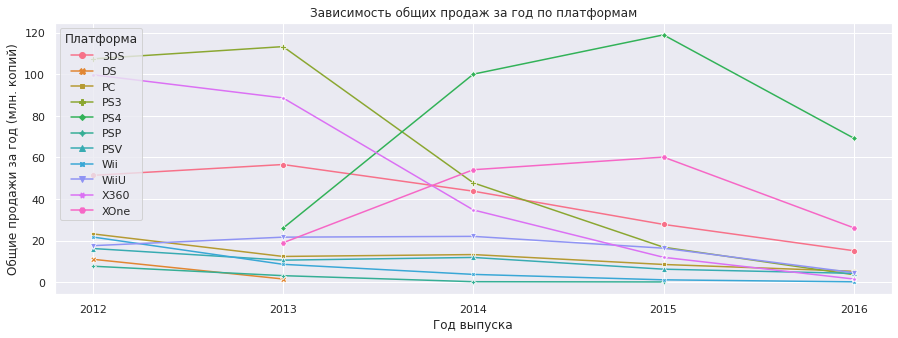

In [347]:
lp = sns.lineplot(data=t12, markers=True, dashes=False)
lp.set(xlabel='Год выпуска',
     ylabel='Общие продажи за год (млн. копий)',
     title='Зависимость общих продаж за год по платформам')
lp.set_xticks([2012, 2013, 2014, 2015, 2016])
lp.legend(title='Платформа', loc='upper left');

Прекрасно. На графике наглядно видно, что к 2016 году есть три популярных плафтормы, игры для которых хорошо продаются (_PS4_, _3DS_, _XOne_) и 8 платформ, игры для которых продаются относительно плохо. К сожалению, продажи на всех платформах с 2015 года падают. 

Если выбирать потенциально прибыльные платформы, то стоит остановиться на тройке лидеров: 
* _PS4_;
* _3DS_;
* _XOne_.

### Исследование разброса значений глобальных продаж игр по платформам

Рассмотрим потенциально прибыльные платформы и построим для них диаграммы размаха, на которых покажем распределение общих продаж игр за рассматриваемый период и за 2016 год.

In [348]:
sns.set(rc={'figure.figsize': (15, 10)})

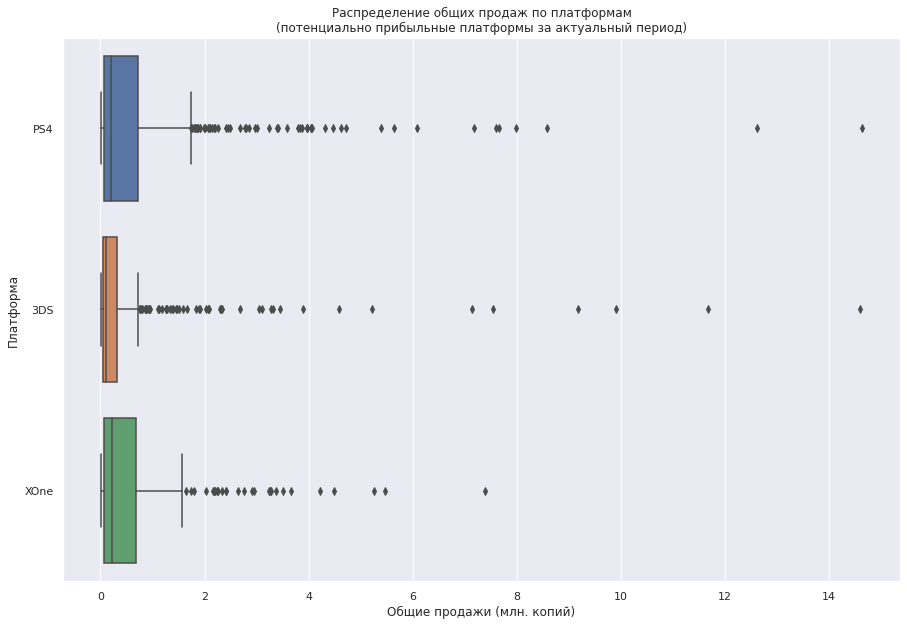

In [349]:
sns.boxplot(data=df12.query('platform in ["PS4", "3DS", "XOne"]')[['platform', 'total_sales']], 
            x='total_sales', y='platform')\
            .set(title="""Распределение общих продаж по платформам
(потенциально прибыльные платформы за актуальный период)""",
                 xlabel='Общие продажи (млн. копий)',
                 ylabel='Платформа');

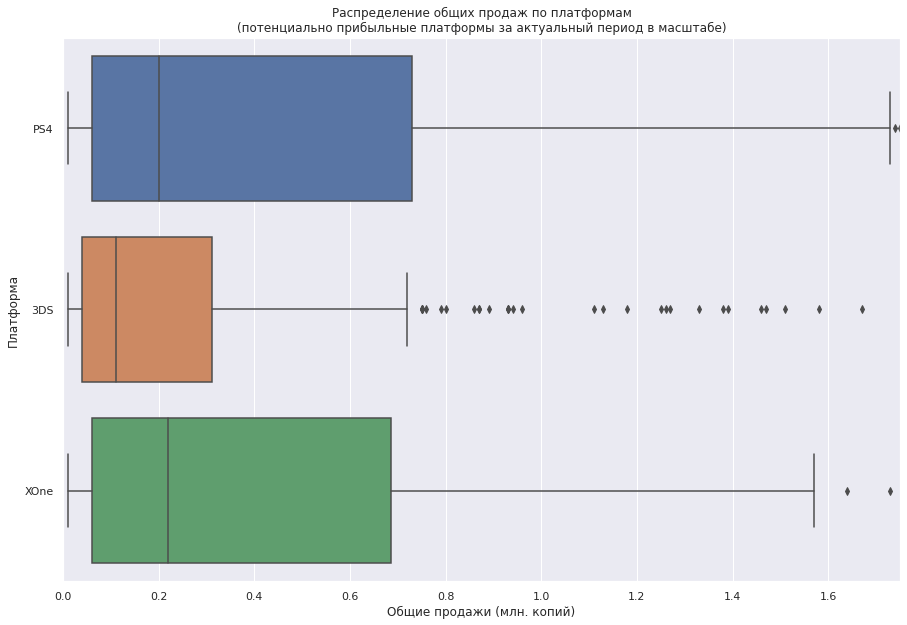

In [350]:
ax = sns.boxplot(data=df12.query('platform in ["PS4", "3DS", "XOne"]')[['platform', 'total_sales']], 
            x='total_sales', y='platform')
ax.set(title="""Распределение общих продаж по платформам
(потенциально прибыльные платформы за актуальный период в масштабе)""",
                 xlabel='Общие продажи (млн. копий)',
                 ylabel='Платформа')
ax.set_xlim([0, 1.75]);

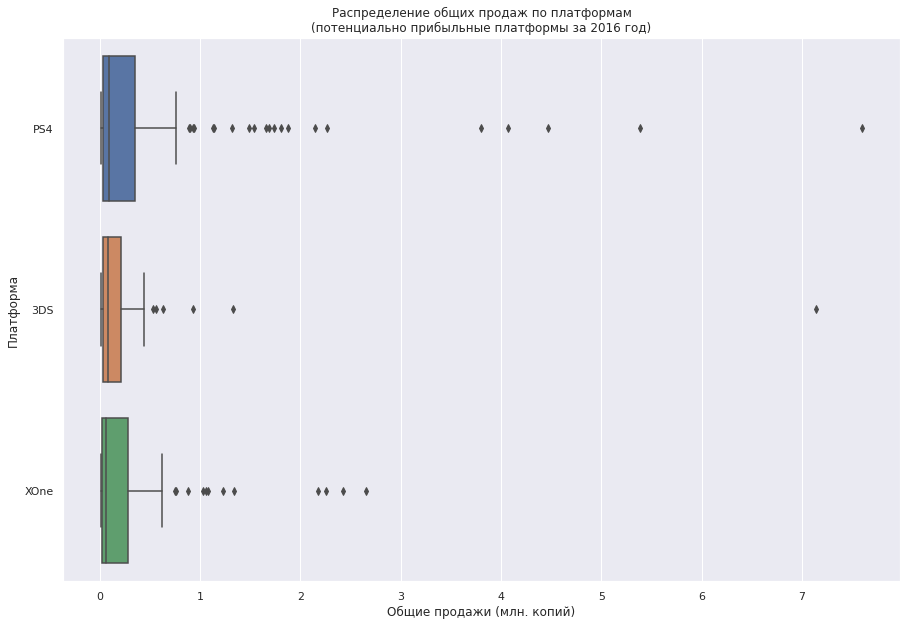

In [351]:
sns.boxplot(data=df12[(df12['platform'].isin(["PS4", "3DS", "XOne"])) & 
     (df12['year_of_release'] == 2016)][['platform', 'total_sales']],
            x='total_sales', y='platform')\
            .set(title="""Распределение общих продаж по платформам
(потенциально прибыльные платформы за 2016 год)""",
                xlabel='Общие продажи (млн. копий)',
                ylabel='Платформа');

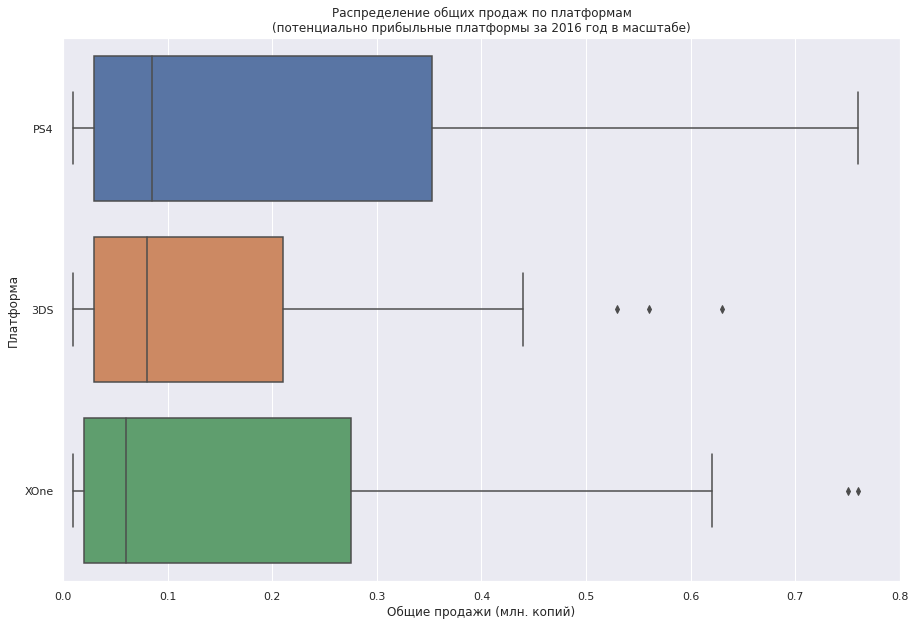

In [352]:
ax = sns.boxplot(data=df12[(df12['platform'].isin(["PS4", "3DS", "XOne"])) & 
     (df12['year_of_release'] == 2016)][['platform', 'total_sales']],
            x='total_sales', y='platform')
ax.set(title="""Распределение общих продаж по платформам
(потенциально прибыльные платформы за 2016 год в масштабе)""",
                xlabel='Общие продажи (млн. копий)',
                ylabel='Платформа')
ax.set_xlim([0, 0.8]);

**Вывод:**

По построенным графикам видно, что наше предположение о потенциально прибыльных платформах не лишено оснований. Для этих платформ в 2016 году выходило сравнительно много игр с очень высокими общими продажами. По этому показателю три выбранных платформы значительно опережают конкурентов.

На графиках за 2016 год видно, что у платформы _PS4_ среднее общих продаж немного быше, чем у платформ-конкурентов, 75-й квартиль находится в районе 0,35 млн копий, что выше, чем у _3DS_ и _XOne_.

### Исследование влияния отзывов пользователей и критиков на общие продажи по платформам

Посмотрим как отзывы и критики влияют на общие продажи по платформам. Построим диаграммы рассеяния и посчитаем корреляции. Будем анализировать данные за актуальный период для трёх платформ-лидеров и прочих платформ.

#### PS4

In [353]:
corr = df12.query('platform=="PS4"')[['critic_score', 'user_score', 'total_sales']].corr()

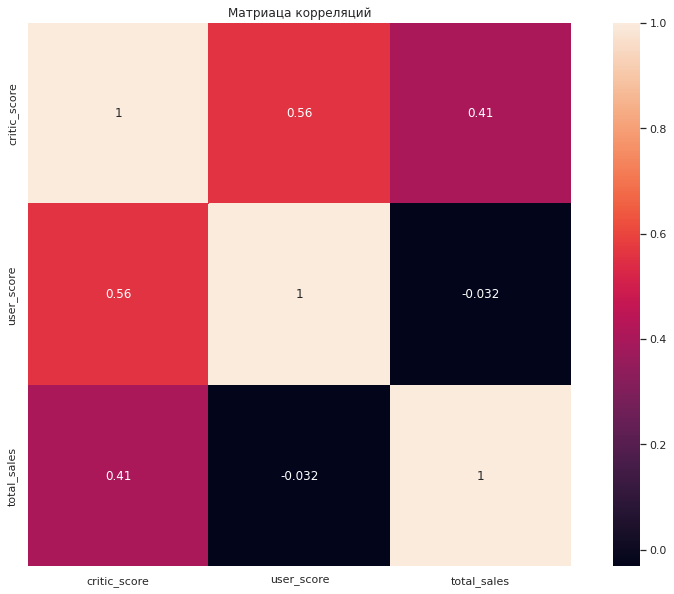

In [354]:
sns.heatmap(corr, annot=True, square=True)\
.set(title='Матриаца корреляций');

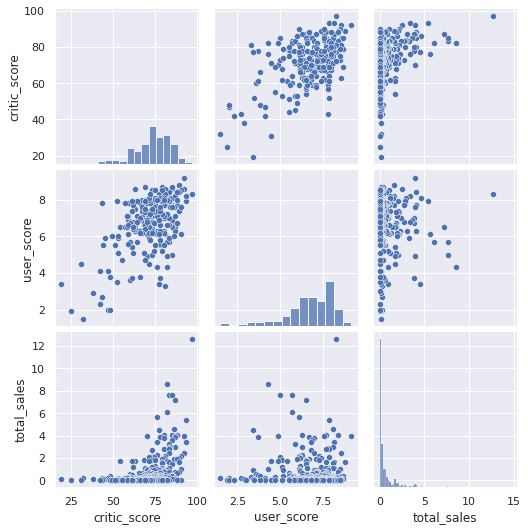

In [355]:
sns.pairplot(df12.query('platform=="PS4"')[['critic_score', 'user_score', 'total_sales']]);

**Вывод:**

Наблюдается средняя положительная корреляция между общими продажами и отзывами критиков. Корреляции общих продаж и отзывов пользователей нет.

#### 3DS

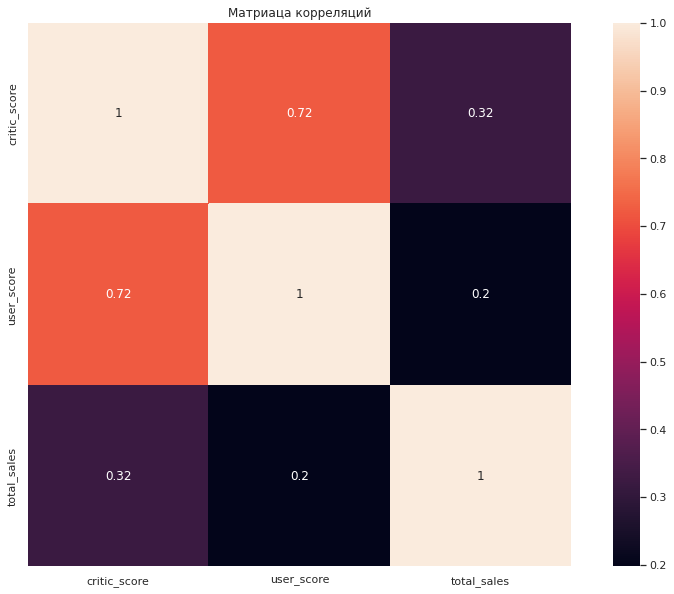

In [356]:
corr = df12.query('platform=="3DS"')[['critic_score', 'user_score', 'total_sales']].corr()
sns.heatmap(corr, annot=True, square=True)\
.set(title='Матриаца корреляций');

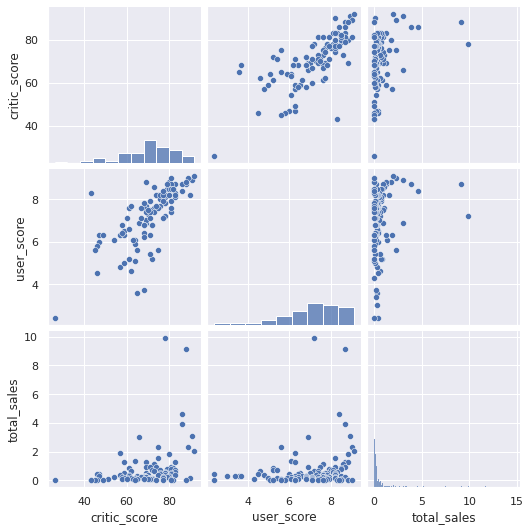

In [357]:
sns.pairplot(df12.query('platform=="3DS"')[['critic_score', 'user_score', 'total_sales']]);

**Вывод:**

Наблюдается слабая положительная корреляция между общими продажами и отзывами критиков, общими продажами и отзывами пользователей.

#### XOne

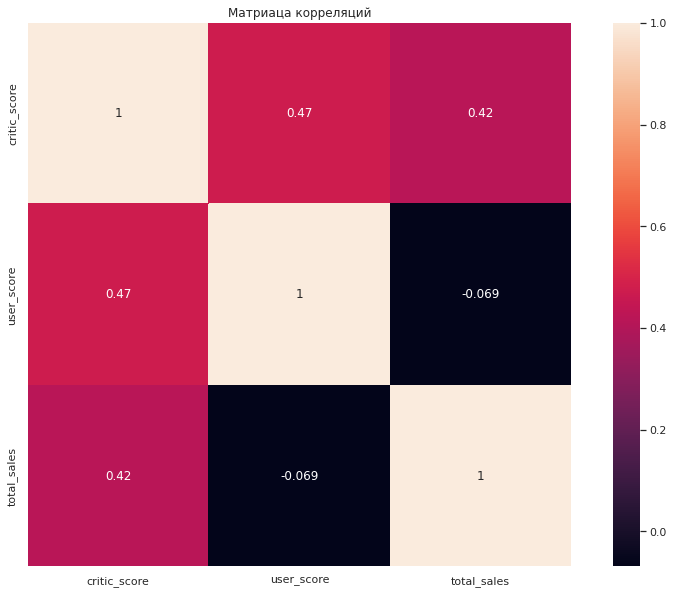

In [358]:
corr = df12.query('platform=="XOne"')[['critic_score', 'user_score', 'total_sales']].corr()
sns.heatmap(corr, annot=True, square=True)\
.set(title='Матриаца корреляций');

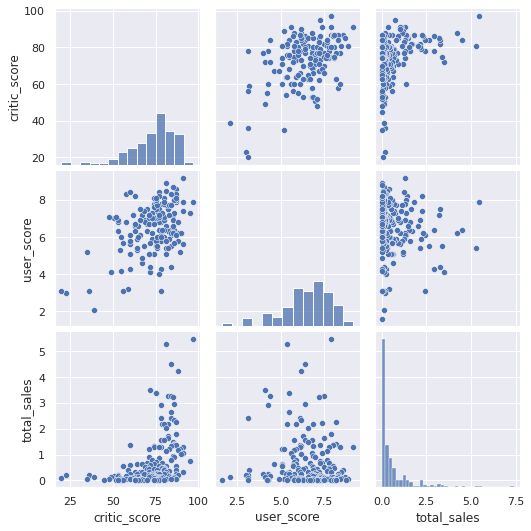

In [359]:
sns.pairplot(df12.query('platform=="XOne"')[['critic_score', 'user_score', 'total_sales']]);

**Вывод:**

Наблюдается средняя положительная корреляция между общими продажами и отзывами критиков. Корреляции общих продаж и отзывов пользователей нет.

#### Прочие платформы

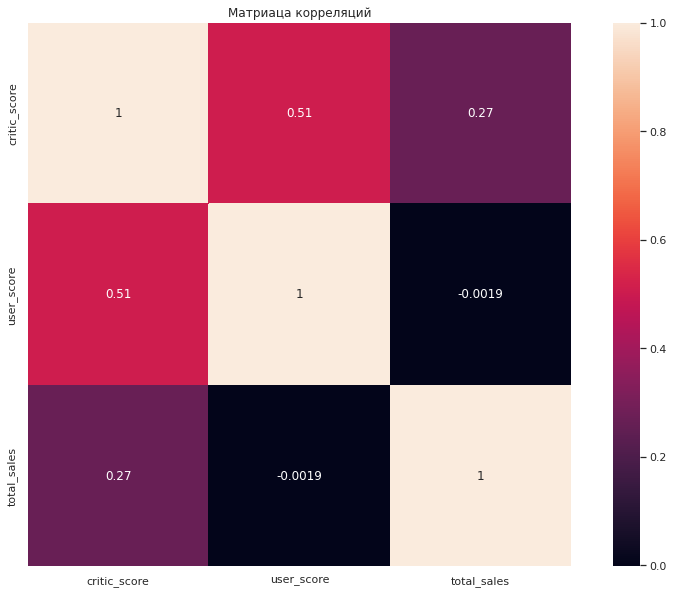

In [360]:
corr = df12.query('platform not in ["PS4", "3DS", "XOne"]')[['critic_score', 'user_score', 'total_sales']].corr()
sns.heatmap(corr, annot=True, square=True)\
.set(title='Матриаца корреляций');

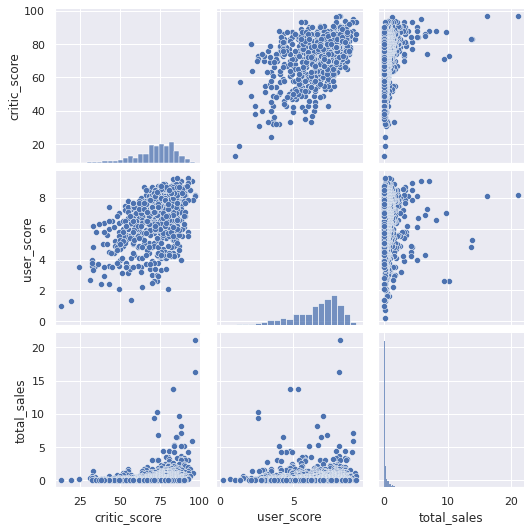

In [361]:
sns.pairplot(df12.query('platform not in ["PS4", "3DS", "XOne"]')[['critic_score', 'user_score', 'total_sales']]);

Для прочих платформ наблюдается низкая положительная корреляция между отзывами критиков и общими продажами. Корреляции между отзывами пользователей и общими продажами нет.

#### Общий вывод

На трёх проанализированных платформах наблюдается некоторая положительная корреляция между отзывами критиков и общими продажами. Для всех трёх платформ корреляции между отзывами пользователей и общими продажами либо нет, либо она очень слабая.

Для прочих платформ наблюдается ещё более низкая положительная корреляция между отзывами критиков и общими продажами. Корреляции между отзывами пользователей и общими продажами нет.

### Исследование распределения игр по жанрам

Посмотрим на распределение игр по жанрам, попробуем выделить самые прибыльные жанры игр. 

In [362]:
genre_grp = df12.groupby('genre')\
.agg({'total_sales': 'mean'})\
.sort_values(by='total_sales')

In [363]:
sns.set(rc={'figure.figsize': (15, 5)})

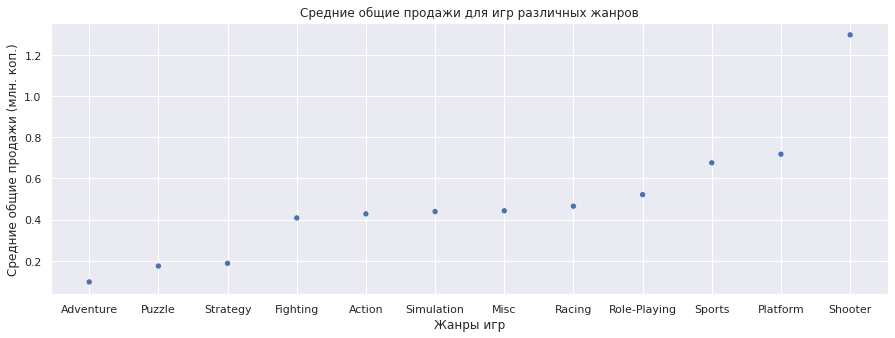

In [364]:
sns.scatterplot(data=genre_grp, legend=False)\
.set(title='Средние общие продажи для игр различных жанров',
     xlabel='Жанры игр',
     ylabel='Средние общие продажи (млн. коп.)');

**Вывод:**

Из построенного графика видно, что наибольшие средние общие продажи наблюдаются у игр в жанрах _shooter_, _platform_, _sports_ и _role-playing_. У игр жанров _simulation_, _racing_, _misc_ (прочие), _action_ и _fighting_ средние общие продажи примерно равны, у игр жанров _strategy_, _puzzle_ и _adventure_ они ниже.

## Составление портретов пользователей каждого региона

Посмотрим, насколько пользователи разных регионов отличаются друг от друга. 

На этапе подготовки данных мы обнаружили, что в колонке `rating` есть много пропусков данных. Возможно они возникли из-за технической ошибки, но может быть для каких-то игр (например, разрабатываемых за пределами США) рейтинг просто не присваивается. Произведём замену пропущенных данных в колонке `rating` на букву _X_.

In [365]:
df12.loc[:, 'rating'] = df12.loc[:, 'rating'].fillna(value='X')

In [366]:
# check
df12['rating'].value_counts().to_frame()

,rating
X,1275
M,498
T,412
E,395
E10+,306


### Пользователи из Северной Америки

Определим, игры на каких платформах пользователи из Северной Америки покупают больше всего.

In [367]:
df12.groupby('platform').agg({'na_sales': 'mean'})\
.sort_values(by='na_sales', ascending=False).head()

,na_sales
platform,
X360,0.479623
XOne,0.377004
Wii,0.323148
PS4,0.277398
WiiU,0.259184


**Вывод:**

Средние продажи пользователям из Северной Америки больше всего для платформ _X360_, _XOne_, _Wii_, _PS4_, _WiiU_.

Определим, игры каких жанров пользователи из Северной Америки покупают больше всего.

In [368]:
df12.groupby('genre').agg({'na_sales': 'mean'})\
.sort_values(by='na_sales', ascending=False).head()

,na_sales
genre,
Shooter,0.616043
Sports,0.304216
Platform,0.298588
Misc,0.198906
Fighting,0.181560


**Вывод:**

Видно, что по популярности лидируют жанры _shooter_, _sports_ и _platform_, популярность жанров _fighting_ и прочие ниже.

Определим, влияет ли рейтинг _ESRB_ на продажи пользователям из Северной Америки.

In [369]:
df12.groupby('rating').agg({'na_sales': 'mean'})\
.sort_values(by='na_sales', ascending=False).head()

,na_sales
rating,
M,0.465000
E,0.289544
E10+,0.247386
T,0.160243
X,0.081027


**Вывод:**

Видно, что рейтинг _ESRB_ сильно влияет на средние продажи пользователям из Северной Америки. Больше всего продаются игры с рейтингом _M (Mature, for ages 17 and older)_, средние продажи игр с рейтингами _E (Everyone, for all ages)_, _E10+ (Everyone 10+, for ages 10 and older)_, _T (Teen, for ages 13 and older)_ ниже. Хуже всего продаются игры без рейтинга _(X)_.

### Пользователи из Европы

Определим, игры на каких платформах пользователи из Европы покупают больше всего.

In [370]:
df12.groupby('platform').agg({'eu_sales': 'mean'})\
.sort_values(by='eu_sales', ascending=False).head()

,eu_sales
platform,
PS4,0.359923
X360,0.255205
Wii,0.220741
PS3,0.216755
XOne,0.208866


**Вывод:**

Средние продажи пользователям из Европы больше всего для платформ _PS4_, _X360_, _Wii_, _PS3_, _XOne_. Стоит отметить, что по составу пятёрки лидеров Европа почти не отличается от Северной Америки.

Определим, игры каких жанров пользователи из Европы покупают больше всего.

In [371]:
df12.groupby('genre').agg({'eu_sales': 'mean'})\
.sort_values(by='eu_sales', ascending=False).head()

,eu_sales
genre,
Shooter,0.482851
Sports,0.257799
Platform,0.251882
Racing,0.237304
Simulation,0.181875


**Вывод:**

Видно, что по популярности лидируют жанры _shooter_, _sports_, _platform_ и _racing_, популярность жанра _simulation_ ниже. Здесь пользователи из Европы также похожи на пользователей из Северной Америки, но в европейскую пятёрку лидеров выбились жанры _racing_ и _simulation_.

Определим, влияет ли рейтинг _ESRB_ на продажи пользователям из Европы.

In [372]:
df12.groupby('rating').agg({'eu_sales': 'mean'})\
.sort_values(by='eu_sales', ascending=False).head()

,eu_sales
rating,
M,0.389478
E,0.286152
E10+,0.180948
T,0.128544
X,0.071765


**Вывод:**

Видно, что рейтинг _ESRB_ сильно влияет на средние продажи пользователям из Европы. Больше всего продаются игры с рейтингом _M (Mature, for ages 17 and older)_, средние продажи игр с рейтингами _E (Everyone, for all ages)_, _E10+ (Everyone 10+, for ages 10 and older)_, _T (Teen, for ages 13 and older)_ ниже. Игры без рейтинга продаются хуже всего. В этом пользователи из Европы схожи с пользователями из Северной Америки.

### Пользователи из Японии

Определим, игры на каких платформах пользователи из Японии покупают больше всего.

In [373]:
df12.groupby('platform').agg({'jp_sales': 'mean'})\
.sort_values(by='jp_sales', ascending=False).head()

,jp_sales
platform,
3DS,0.221692
DS,0.120000
WiiU,0.088503
PS3,0.071582
Wii,0.062778


**Вывод:**

Средние продажи пользователям из Японии больше всего для платформ _3DS_, _DS_, _WiiU_, _PS3_, _Wii_. Эти результаты существенно отличаются от предпочтений пользователей из США и Европы. В пятёрке лидеров нет ни _PS4_, ни _X360_, ни _XOne_.

Определим, игры каких жанров пользователи из Японии покупают больше всего.

In [374]:
df12.groupby('genre').agg({'jp_sales': 'mean'})\
.sort_values(by='jp_sales', ascending=False).head()

,jp_sales
genre,
Role-Playing,0.176865
Simulation,0.130125
Platform,0.101529
Fighting,0.086606
Puzzle,0.076429


**Вывод:**

Видно, что по популярности лидируют жанры _role-playing_, _simulation_ и _platform_, популярность жанров _fighting_ и _puzzle_ ниже. Видно, что и здесь предпочтения японцев отличаются от предпочтений европейцев и американцев. Жанр _shooter_ даже не выбился в пятёрку лидеров!

Определим, влияет ли рейтинг _ESRB_ на продажи пользователям из Японии.

In [375]:
df12.groupby('rating').agg({'jp_sales': 'mean'})\
.sort_values(by='jp_sales', ascending=False).head()

,jp_sales
rating,
X,0.085365
E,0.071722
T,0.063155
M,0.042570
E10+,0.026765


**Вывод:**

Видно, что рейтинг _ESRB_ влияет на средние продажи пользователям из Японии, но иначе, чем в США и Европе. Больше всего продаются игры без рейтинга _(X)_, с рейтингом _E (Everyone, for all ages)_ и _T (Teen, for ages 13 and older)_, средние продажи игр с рейтингами _M (Mature, for ages 17 and older)_, _E10+ (Everyone 10+, for ages 10 and older)_,  ниже. Удивительная страна! Было бы интересно сравнить продажи игр в Японии с продажами в Китае, например.

Скорее всего хорошие продажи игр без рейтинга можно объяснить тем, что японские разработчики игр не получают рейтинги от американской [ESRB](https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board), в Японии есть своё рейтинговое агентство: [CERO](https://en.wikipedia.org/wiki/Computer_Entertainment_Rating_Organization). Похоже, что японцы просто предпочитают игры отечественных разработчиков.

## Проверка гипотез

### Средние пользовательские рейтинги платформ _Xbox One_ и _PC_ одинаковые

Проверим гипотезу, что средние пользовательские рейтинги на платформах _Xbox One_ и _PC_ одинаковые. В этом случае нулевая гипотеза $H_0$ будет звучать так: среднее рейтингов для генеральной совокупности «пользователи Xbox One» равно среднему рейтингов генеральной совокуности «пользователи PC». Альтернативная гипотеза $H_1$ будет звучать так: между средними рейтингов двух генеральных совокупностей есть значимые различия.
Установим уровень значимости $\alpha = 0.05$.

In [376]:
alpha = 0.05

In [377]:
sample_xbox = df12.query('platform=="XOne"')['user_score']

In [378]:
sample_pc = df12.query('platform=="PC"')['user_score']

In [379]:
sample_xbox = sample_xbox.dropna()
sample_pc = sample_pc.dropna()

In [380]:
results = st.ttest_ind(sample_xbox, sample_pc)

In [381]:
print('p-значение: ', results.pvalue)

p-значение:  0.5535080500643661


In [382]:
if results.pvalue > alpha:
    print('Гипотезу H_0 отвергнуть нельзя')
else:
    print('Гипотезу H_0 необходимо отвергнуть')

Гипотезу H_0 отвергнуть нельзя


**Вывод:**

Проведённое исследование показало, что гипотезу $H_0$ о равенстве средних отклонить нельзя, можно считать, что средние пользовательские рейтинги для обеих платформ действительно одинаковые.

### Средние пользовательские рейтинги жанров Action и Sports разные

Проверим гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные. В этом случае нулевая гипотеза $H_0$ будет звучать так: среднее рейтингов для генеральной совокупности «экшн-игры» равно среднему рейтингов генеральной совокуности «спортивные игры». Альтернативная гипотеза $H_1$ будет звучать так: между средними рейтингов двух генеральных совокупностей есть значимые различия.

In [383]:
sample_action = df12.query('genre=="Action"')['user_score'].dropna()
sample_sports = df12.query('genre=="Sports"')['user_score'].dropna()

In [384]:
results = st.ttest_ind(sample_action, sample_sports)

In [385]:
print('p-значение: ', results.pvalue)

p-значение:  3.7163089460934874e-26


In [386]:
if results.pvalue > alpha:
    print('Гипотезу H_0 отвергнуть нельзя')
else:
    print('Гипотезу H_0 необходимо отвергнуть')

Гипотезу H_0 необходимо отвергнуть


**Вывод:**

Проведённое исследование показало, что гипотезу $H_0$ о равенстве средних можно отклонить. Похоже, что средние пользовательские рейтинги действительно разные.

## Общий вывод по проекту

Имеется файл с историческими данными о продажах игр, оценках пользователей и экспертов, жанрами и платформами (например, _Xbox_ или _PlayStation_). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Файл с данными был подготовлен в 2016 году, исследование проводится для 2017 года.

При работе над проектом был проанализирован ряд характеристик, которые потенциально могут влиять на продажи игр. Было установлено, что:
* в 2016 году наиболее перспективными платформами были _PS4_, _3DS_, _XOne_;
* отзывы критиков слабо влияют на общие продажи игр;
* отзывы пользователей практически не влияют на общие продажи игр;
* лучше всего продаются игры в жанре «шутер»;
* предпочтения пользователей из Европы и США в целом схожи: они предпочитают играть в шутеры и спортивные игры на популярных платформах, чаще всего покупают игры с рейтингом M;
* предпочтения пользователей из Японии иные: они предпочитают ролевые игры и сумуляции на платформах 3DS и DS, при этом мы не можем сделать полноценный и однозначный вывод о влиянии рейтингов на продажи игр: для этого необходимо добавить в таблицу данные о рейтингах японских игр, присвоенных организацией [CERO](https://en.wikipedia.org/wiki/Computer_Entertainment_Rating_Organization);
* средние пользовательские рейтинги для платформ _Xbox One_ и _PC_ не различаются;
* средние пользовательские рейтинги для игр жанров _Action_ и _Sports_ значимо различаются.

Полученные результаты можно использовать на этапе подготовки к разработке новых игр для выбора платформ, жанра и потенциальных рынков сбыта.